# Pytorch basics

Цели:

* Познакомиться с тензорами и как с ними работать
* Получить представление о функциях потерь, градиентном спуске и оптимизации
* Познакомиться с супер-краткой историей генеративного AI

Содержание:

* [Основы pytorch](#basics)
  * [тензоры](#tensors)
  * [операции с тензорами](#operations)
  * [представление изображений в виде тензоров](#images)
  * [трансформации тензоров](#transform)
* [Градиентный спуск](#descent)
* [Методы оптимизации](#loss)
* [Примитивная нейросеть](#nn)
* [История генеративного AI](#history)

Ссылки:

* D. Foster Generative Deep Learning, 2nd Edition
* [Pytorch basics lesson from The Generative Landscape course](https://johnowhitaker.github.io/tglcourse/pytorch_basics.html)


<a name="basics"></a>
## Основы pytorch

NOTE: Ноутбук построен на основе одноимённого урока из курса The Generative Landscape on John Whitaker (ссылка выше)


In [ ]:
import torch
import requests
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from PIL import Image
from io import BytesIO
#
import IPython.display as ipd

def load_image_pil(fn, size=None):
    im = Image.open(fn).convert('RGB')
    if size != None:
        im = im.resize(size)
    return im

def pil_from_url(url, size=None):
    response = requests.get(url)
    im = Image.open(BytesIO(response.content)).convert('RGB')
    if size != None:
        im = im.resize(size)
    return im

def pil_to_tensor(im):
    im = np.array(im) # To numpy array
    im = torch.tensor(im) # To tensor
    im = im.permute(2, 0, 1) # Rearrange dimensions
    im = im.unsqueeze(0) # Add batch dimension first
    return im/255.0 # Scale down to (0, 1)

def tensor_to_pil(tensor_im):
    tensor_im = tensor_im.squeeze() # In case there is a batch dimension
    tensor_im = tensor_im.detach().cpu() # Detach from computational graph
    tensor_im = tensor_im.permute(1, 2, 0) # Rearrange the channels
    tensor_im = tensor_im.clip(0, 1)*255 # Note that we clip to (0, 1) before scaling to (0, 255)
    im_array = np.array(tensor_im).astype(np.uint8) # Convert to int as required by PIL
    im = Image.fromarray(im_array) # Convert to PIL image
    return im

<a name="tensors"></a>
### Тензоры

Создание тензоров из списка

In [ ]:
torch.tensor([0, 1, 2])

tensor([0, 1, 2])

из кортежа

In [ ]:
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)
print(f"Tensor shape: {b.shape}")
b

Tensor shape: torch.Size([2, 2])


tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])

или numpy-массива

In [ ]:
c = np.ones([2, 3])
torch.tensor(c)

tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

Другие конструкторы, аргументы определяют размер тензора

In [ ]:
x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[1.0713e-28, 3.1540e-41, 1.1051e-28, 3.1540e-41, 7.8699e+28]]])


`.empty()` возвращает не нули, а какие-то рандомные числа. В отличие от `.zeros()`, который инициализирует тензор строго с нулями, `.empty()` просто аллоцирует память, что работает немного быстрее.

Конструкторы для случайных чисел

In [ ]:
# uniform distribution
a = torch.rand(1, 3)

# normal distribution
b = torch.randn(3, 4)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")

Tensor a: tensor([[0.8274, 0.5125, 0.0714]])
Tensor b: tensor([[-0.6696,  0.4547, -1.9495, -0.8356],
        [-0.7538, -0.3375,  1.5976, -0.7722],
        [-0.3633,  0.2247,  0.5142,  1.3930]])


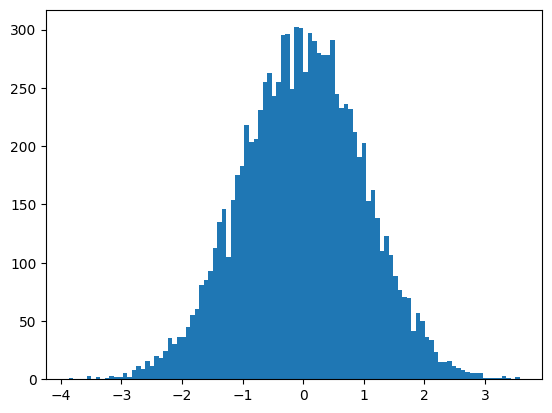

In [ ]:
plt.hist(torch.randn(10000), bins=100);

Есть конструкторы для тензоров, которые позволяют создавать тензоры с таким же размером, как заданные:

In [ ]:
c = torch.zeros_like(a)
d = torch.rand_like(c)
print(f"Tensor c: {c}")
print(f"Tensor d: {d}")

Tensor c: tensor([[0., 0., 0.]])
Tensor d: tensor([[0.7038, 0.1876, 0.0834]])


`.arange()` и `.linspace()` работают также, как в numpy

In [ ]:
a = torch.arange(0, 1, step=0.1) # Equivalent to np.arange(0, 10, step=1)
b = torch.linspace(0, 5, steps=12) # np.linspace(0, 5, num=11)

print(f"Tensor a: {a}\n")
print(f"Tensor b: {b}\n")

Tensor a: tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])

Tensor b: tensor([0.0000, 0.4545, 0.9091, 1.3636, 1.8182, 2.2727, 2.7273, 3.1818, 3.6364,
        4.0909, 4.5455, 5.0000])



<a name="operations"></a>
### Операции с тензорами

Можно выполнять операции с тензорами с помощью методов библиотеки torch. Кроме того, в pytorch большинство python-операторов переопределены и можно пользоваться ими. Стандартные арифметические операторы `(+, -, *, /, и **)` работают как соответствующие поэлементные операции.

#### Создание тензоров

In [ ]:
x = torch.tensor([1, 2, 4, 8])
y = torch.tensor([1, 2, 3, 4])
print('Сложение с помощью torch.add:', torch.add(x, y))
print('Сложение с помощью "+":', x + y) # The same
print('И другие операции:')
x + y, x - y, x * y, x / y, x**y  # The ** operator is exponentiation

Сложение с помощью torch.add: tensor([ 2,  4,  7, 12])
Сложение с помощью "+": tensor([ 2,  4,  7, 12])
И другие операции:


(tensor([ 2,  4,  7, 12]),
 tensor([0, 0, 1, 4]),
 tensor([ 1,  4, 12, 32]),
 tensor([1.0000, 1.0000, 1.3333, 2.0000]),
 tensor([   1,    4,   64, 4096]))

У тензоров есть много встроенных методов, например `.mean()` или `.sum()` (полный список: https://pytorch.org/docs/stable/tensors.html). Однако, при работе с многомерными тензорами нужно быть внимательным с размерностями.

In [ ]:
x = torch.rand(2, 3)
print('x:\n', x)
print(f"Сумма всех элементов x: {x.sum()}")
print(f"Сумма строк x: {x.sum(axis=0)}")
print(f"Сумма столбцов x: {x.sum(axis=1)}")

x:
 tensor([[0.3733, 0.7838, 0.5002],
        [0.2961, 0.3843, 0.1668],
        [0.3935, 0.1864, 0.1581]])
Сумма всех элементов x: 3.2424821853637695
Сумма столбцов x: tensor([1.0628, 1.3545, 0.8251])
Сумма строк x: tensor([1.6573, 0.8472, 0.7379])


Большинство арифметических операторов поэлементные. Для матричного умножения есть `torch.matmul()` или символ `@`. Для скалярного произведения одномерных векторов можно использовать `torch.dot()`.

Для траспонирования двумерных векторов используются `torch.t(`) или `Tensor.T`.

In [ ]:
a = torch.rand(2, 3)
b = a.T
print('a.shape:', a.shape, 'b.shape:', b.shape)
print('a:', a)
print('b:', b)
print(a@b) # Matrix multiplication of a 2x3 with a 3x2 matrix gives a 2x2 result.

a.shape: torch.Size([2, 3]) b.shape: torch.Size([3, 2])
a: tensor([[0.7765, 0.2682, 0.7410],
        [0.8398, 0.9468, 0.9821]])
b: tensor([[0.7765, 0.8398],
        [0.2682, 0.9468],
        [0.7410, 0.9821]])
tensor([[1.2239, 1.6338],
        [1.6338, 2.5662]])


#### Работа с тензорами

Помимо математических операций, часто нужно получить доступ к некоторым элементам или их множествам, или изменить размер тензора.
Ниже несколько примеров таких операций.

In [ ]:
# Indexing tensors
x = torch.arange(0, 10)
print(x)
print(x[-1])
print(x[1:3]) # From index 1 up to but NOT INCLUDING index 3
print(x[:-2])

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor(9)
tensor([1, 2])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [ ]:
print('Starting tensor:')
z = torch.arange(1, 13)
print('z.shape:', z.shape)
print(f'z: {z}\n')

print('Reshaping to (3, 4):')
z = z.reshape(3, 4)
print('z.shape:', z.shape)
print(f'z:{z}\n')

print('Flattening:')
z = z.flatten()
print('z.shape:', z.shape)
print(f'z: {z}')

Starting tensor:
z.shape: torch.Size([12])
z: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Reshaping to (3, 4):
z.shape: torch.Size([3, 4])
z:tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12]])

Flattening:
z.shape: torch.Size([12])
z: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Для конкатенации тензоров служит `torch.cat` - посмотрите на примеры ниже и обратите внимание как указанный размер влияет на результат:

In [ ]:
# Create two tensors of the same shape
x = torch.arange(12, dtype=torch.float32).reshape((3, 4))
y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

# concatenate them along rows
cat_rows = torch.cat((x, y), dim=0)

# concatenate along columns
cat_cols = torch.cat((x, y), dim=1)

# printing outputs
print('Concatenated by rows: shape{} \n {}'.format(list(cat_rows.shape), cat_rows))
print('\n Concatenated by colums: shape{}  \n {}'.format(list(cat_cols.shape), cat_cols))

Concatenated by rows: shape[6, 4] 
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [ 2.,  1.,  4.,  3.],
        [ 1.,  2.,  3.,  4.],
        [ 4.,  3.,  2.,  1.]])

 Concatenated by colums: shape[3, 8]  
 tensor([[ 0.,  1.,  2.,  3.,  2.,  1.,  4.,  3.],
        [ 4.,  5.,  6.,  7.,  1.,  2.,  3.,  4.],
        [ 8.,  9., 10., 11.,  4.,  3.,  2.,  1.]])


#### Убираем пустую размерность (squeeze)

При работе с батчами, часто приходится сталкиваться с единичными (singleton) размерностями, например [1,10] или [256, 1, 3]. Такие размерности могут создать сложности с матричными операциями.

Для того, чтобы убрать единичные размености используется метод `.squeeze()`, а наооборот для добавления - метод `.unsqueeze()`.

In [ ]:
x = torch.randn(1, 10)
print(x.shape)
print(f"x[0]: {x[0]}") # printing the zeroth element of the tensor will not give us the first number!

torch.Size([1, 10])
x[0]: tensor([-0.3177, -0.4882, -0.4214,  0.4627, -0.1080, -0.1135, -1.6205, -0.8416,
        -1.5820,  1.6113])


Избавимся от единичного измерения:

In [ ]:
x = x.squeeze(0)
print(x.shape)
print(f"x[0]: {x[0]}")

torch.Size([10])
x[0]: -0.31769752502441406


Добавим единичное измерение:

In [ ]:
y = torch.randn(5, 5)
print(f"shape of y: {y.shape}")

y = y.unsqueeze(1) # Note the argument here is 1 - try 0 and 2 and make sure you get a feel for what unsqueeze does.
print(f"shape of y: {y.shape}")

shape of y: torch.Size([5, 5])
shape of y: torch.Size([5, 1, 5])


<a name="images"></a>
### Представление изображений в виде тензоров

In [ ]:
!wget -O frog.png https://github.com/johnowhitaker/tglcourse/blob/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png?raw=true

--2023-08-05 16:07:01--  https://github.com/johnowhitaker/tglcourse/blob/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/johnowhitaker/tglcourse/raw/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png [following]
--2023-08-05 16:07:02--  https://github.com/johnowhitaker/tglcourse/raw/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/johnowhitaker/tglcourse/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png [following]
--2023-08-05 16:07:02--  https://raw.githubusercontent.com/johnowhitaker/tglcourse/f9ef8a82d6a16838dee7f347d5fbcbada3eb060f/images/frog.png
Resolving raw.githubusercontent.com (raw.githubusercontent

#### Картинки как массивы чисел

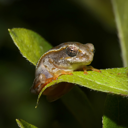

In [ ]:
im = Image.open('./frog.png').convert('RGB').resize((128, 128))
im

In [ ]:
np.array(im).shape # Remove .convert('RGB') in the cell above and see how this changes

(128, 128, 3)

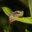

In [ ]:
load_image_pil('frog.png', size=(32, 32))

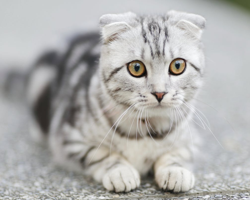

In [ ]:
pil_from_url("https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1", size=(250, 200))

#### Преобразование изображений в тензоры

In [ ]:
im = load_image_pil('frog.png', size=(32, 32))
image_array = np.array(im)
image_array.shape

(32, 32, 3)

Данный массив имеет размерность (32, 32, 3). (3) - это число каналов (Red, Green, Blue). Значения в массиве - целые числа от 0 до 255 (8-bit numbers). Для совместимости с различными инструментами pytorch, изменим порядок измерений так, что число каналов станет идти первым и представим изображения как числа с запятой от 0 до 1:

In [ ]:
tensor_im = torch.tensor(np.array(im)).permute(2, 0, 1)/255.0
tensor_im.shape

torch.Size([3, 32, 32])

In [ ]:
tensor_im.min(), tensor_im.max()

(tensor(0.), tensor(0.7804))

Также для подобных операций есть библиотека torchvision:

In [ ]:
to_tensor_transform = torchvision.transforms.ToTensor()
to_tensor_transform(im).shape

torch.Size([3, 32, 32])

Channels-first представление популярное решение, но не единственное - обращайте на это внимание, когда будете работать с кодом других людей.

Также обычно pytorch работает с батчами данных и тензоры для батчей обычно имеют форму (batch_size, channels, width, height).

Вспомогательные функции из начала ноутбука служат для операций загрузки изображений в тензоры и обратно:

torch.Size([1, 3, 128, 128])
<class 'PIL.Image.Image'>


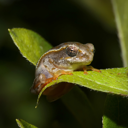

In [ ]:
im = load_image_pil('frog.png', size=(128, 128)) # Load an image
tensor_im = pil_to_tensor(im) # To tensor with our function
print(tensor_im.shape)
im_out = tensor_to_pil(tensor_im) # And back to a PIL imge
print(type(im_out))
im_out

Можно с помощью matplotlib посмотреть, как выглядят изображения по отдельным каналам:

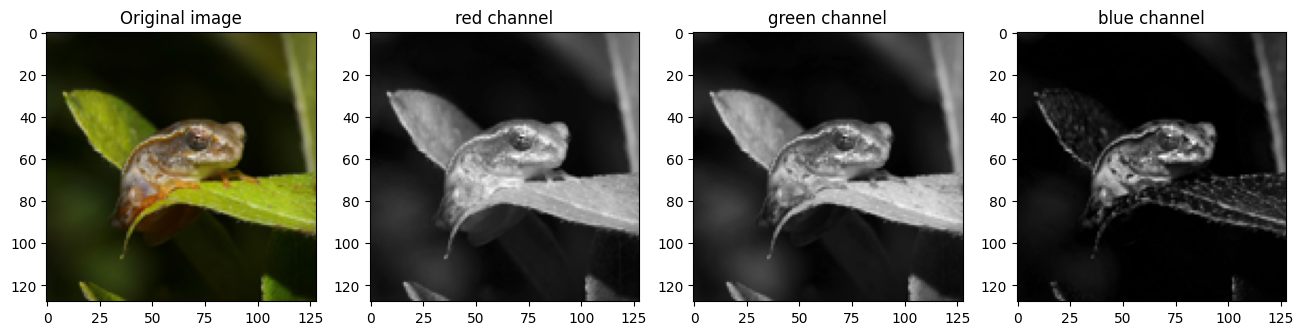

In [ ]:
# Plotting the original image and the three color channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(tensor_im[0].permute(1, 2, 0)) # Note: we need to rearrange the color channels
axs[0].set_title('Original image')
colors = ['red', 'green', 'blue']
for i in range(1, 4):
    axs[i].imshow(tensor_im[0][i-1], cmap='gray')
    axs[i].set_title(f'{colors[i-1]} channel')

Так как это тензор, то можно выделить его часть с помощью индексов:

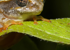

In [ ]:
cropped = tensor_im[0, :, 50:100, 50:120] # First image in batch, all channels, 50px high and 70 wide starting from (50, 50) (top left is 0, 0)
tensor_to_pil(cropped)

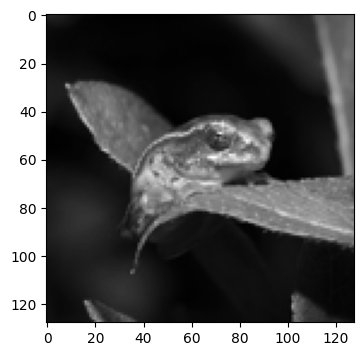

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.imshow(tensor_im.squeeze(0).mean(0), cmap='gray')

<a name="transform"></a>
#### Преобразования тензоров

Для преобразований изображений, таких как zoom, повороты, деформации или обрезка. Это можно делать с помощью python-библиотеки PIL, но для производительности лучше это делать непосредственно с тензорами, для этого служит библиотека torchvision. Torchvision содержит много различных трансформаций, включая случайные преобразования, удобные для аугментации:

In [ ]:
print(dir(torchvision.transforms)[:-16])

['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'ElasticTransform', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor']


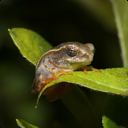

In [ ]:
transform = torchvision.transforms.RandomAffine(30)
tensor_to_pil(transform(tensor_im))

<a name="descent"></a>
## Градиентный спуск

Рассмотрим следующую ситуацию. Допустим, у нас есть:

- Функция (может быть нейронной сетью, может быть уравнением прямой линии...), которая принимает некоторые входные данные и производит некоторые выходные данные на основе набора параметров - назовем их `w`
- Некоторая мера того, насколько хорошо эта функция работает. Может быть, это то, насколько плохо функция описывает какую-то закономерность в ваших данных, или насколько хорошо сеть справляется с задачей классификации. Давайте назовем эту меру "потери", где цель состоит в том, чтобы сделать ее как можно меньше.

Часто возникает вопрос: «Как найти набор параметров, дающий минимальное значение потерь?».

Есть несколько способов, которыми мы могли бы попытаться решить эту проблему. Самыми простыми могут быть:

- Попробовать все возможные значения для всех параметров
- Перебрать несколько случайным образом и сохранить лучшие

Ясно, что оба метода имеют серьезные недостатки, и когда мы имеем дело с тысячами или миллионами параметров, невозможно попробовать все возможные комбинации. Значит, нужен более разумный подход.

### Алгоритм градиентного спуска

<img src="https://shashank-ojha.github.io/ParallelGradientDescent/non-convex.png" alt="Gradient Descent" width="600"/>

Image credit: [shashank-ojha.github.io](https://shashank-ojha.github.io/ParallelGradientDescent/)

Что, если бы мы могли начать с некоторого начального значения параметров, а затем немного их изменить, чтобы получить улучшение? В идеале, для каждого параметра мы хотели бы знать, что произойдет с потерями, когда мы немного подкорректируем этот параметр вверх или вниз. Формально мы хотели бы знать **градиент потерь по этому параметру**. Вы можете думать о градиенте как о том, что он говорит нам, в каком направлении двигаться, чтобы получить наибольшее увеличение (или уменьшение потерь, если мы идем в противоположном направлении).

Если мы сможем найти эти градиенты, то разумным методом поиска хорошего набора параметров для решения данной проблемы будет:

1. Начните с некоторых случайных параметров
2. Найдите градиент потерь по каждому параметру
3. Обновите каждый параметр таким образом, чтобы вы немного сдвинулись в направлении наискорейшего спуска.
4. Вернитесь к шагу 2, найдите градиенты на основе новых значений параметров и повторите все это несколько раз.

Это алгоритм градиентного спуска в двух словах :)

Давайте сделаем пример, где мы сгенерируем некоторые данные, которые примерно соответствуют тренду, и попытаемся аппроксимировать этот тренд прямой линией, которая будет задана двумя параметрами.

### Создание задачи-примера

Создадим обучающие данные, с одним входом (x) одним выходом (y):

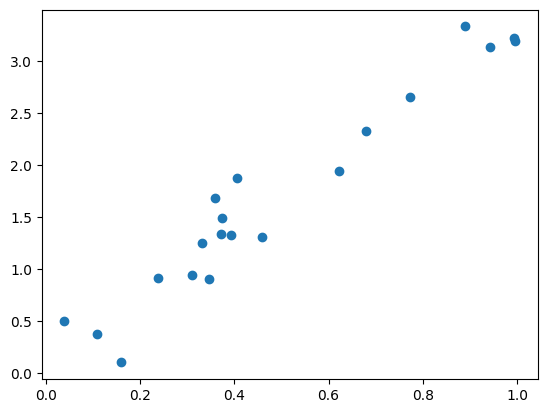

In [ ]:
x = torch.rand(20)
y = 3*x + 0.2 + torch.randn(20)*0.3 # y = ax + b + noise
plt.scatter(x, y) # It's always helpful to visualize what's going on wherever possible.
# plt.plot(x, 3*x + 0.2, color='gray')

### Определим функцию потерь

Мы можем описать линию как функцию `y = ax + b` где a и b - наши параметры. Посмотрим на пару произвольных линий:

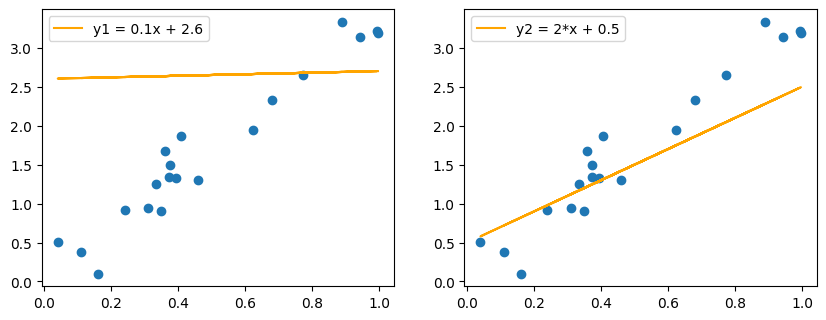

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3.6))
axs[0].scatter(x, y)
axs[0].plot(x, 0.1*x + 2.6, label='y1 = 0.1x + 2.6', c='orange')
axs[0].legend()
axs[1].scatter(x, y)
axs[1].plot(x, 2*x + 0.5, label='y2 = 2*x + 0.5',  c='orange')
axs[1].legend();

Очевидно, что одна из них лучше, чем другая, описывает тенденцию в этих данных. Но как оценить это количественно? Существует несколько показателей, используемых в подобных случаях, одним из которых является "среднеквадратичнаяя ошибка (RMSE)". Звучит пугающе, но все, что мы делаем, это берем ошибки (насколько каждая точка удалена от линии), возводим их в квадрат, суммируем квадраты и затем берем квадратный корень из этой суммы. Больше точек, расположенных дальше от линии -> больше ошибок (квадрат убирает все знаки минус, которые в противном случае могут вызвать проблемы с точками выше/ниже линии) -> больше итоговое значение RMSE. И чем меньше оно, тем лучше. Это и есть наша функция потерь.

Вот один из способов реализации этой функции в коде (существуют также встроенные функции для этого и множество других способов написания):

In [ ]:
def rmse(y, y_pred):
    return torch.mean((y-y_pred)**2)**0.5 # See how many ways you can write this

Используя эту функцию потерь мы можем определить, насколько хорошо эти линии описывают данные:

In [ ]:
y1 = 0.1*x + 2.6
y2 = 2*x + 0.5
print('RMSE for y_hat1 = 0.1x + 2.6:', rmse(y, y1))
print('RMSE for y_hat2 = 2*x + 0.5:', rmse(y, y2))

RMSE for y_hat1 = 0.1x + 2.6: tensor(1.3460)
RMSE for y_hat2 = 2*x + 0.5: tensor(0.4854)


Вторая линия имеет меньшие потери и поэтому лучше подходит. Подкорректируйте параметры и посмотрите, может быть, получится еще лучше.

Возможно вы при этом неявно будете делать градиентый спуск :)

### Вычисление градиентов

Итак, как же найти градиенты? Если вы хорошо дифференцируете, то можете посмотреть на функцию и найти их аналитически. Но это не так просто, если функция сложная или включает много шагов. К счастью, PyTorch делает так называемое автоматическое дифференцирование, которое позволяет отслеживать каждую операцию, происходящую с тензором. Он строит так называемый вычислительный граф, и когда вы хотите вычислить градиенты относительно некоторого конечного результата, вы можете просто вызвать .backward(), и PyTorch проложит путь назад по этому графу, заполняя градиенты на каждом шаге. Мы не будем углубляться в эту тему, но приведем простой пример:

In [ ]:
a = torch.tensor(5.7)
a.requires_grad = True # This is important - by default PyTorch won't track gradients

b = 5*a + 2

c = torch.sin(2*b+0.1)

c

tensor(-0.9871, grad_fn=<SinBackward0>)

Обратите внимание на `grad_fn`. Поскольку `c` зависит от чего-то (`b`), что зависит от тензора, требующего градиент (`a`), PyTorch отслеживает функцию, необходимую для вычисления градиентов. Мы можем посмотреть градиент c относительно `a` с помощью:

In [ ]:
c.backward() # Tell pytorch to propagate the gradients backwards down the chain of operations
a.grad # See the resulting gradient

tensor(-1.6036)

Производная `c` по `a` равна $10\cdot cos(10 \cdot (a + 0.41))$ - подставляя `a=5.7`, мы видим, что это действительно дает ответ `dc/da` = -1.603. Это просто чудесно - мы можем соединить сложные функции в цепочку, и пока все дифференцируемо, мы можем положиться на PyTorch, который сможет работать в обратном направлении и даст нам все необходимые градиенты.

### Градиентный спуск для нашего игрушечного примера

Вернемся к нашему примеру, где мы пытались найти параметры для линии, которая наилучшим образом описывает тенденцию в наших данных.

Мы создаем параметры `w` (инициализированные 2 случайными плавающими числами) и указываем pytorch на необходимость отслеживать градиенты.

Затем, в цикле, мы многократно находим потери, находим градиенты (`loss.backward()`) и соответствующим образом обновляем параметры. Мы могли бы сделать это сами, но PyTorch предоставляет оптимизатор, который выполняет обновление за нас - torch.optim.SGD. Скорость обучения `lr` определяет, размер шага, который мы делаем на каждой итерации.

После завершения цикла мы строим график потерь и видим, что со временем потери уменьшаются.

tensor([0.7971, 0.1210], requires_grad=True)
loss at step 19 : tensor(0.4397, grad_fn=<PowBackward0>)
w at step 19 : tensor([1.9997, 0.7544], requires_grad=True)
loss at step 39 : tensor(0.2971, grad_fn=<PowBackward0>)
w at step 39 : tensor([2.6680, 0.4039], requires_grad=True)
loss at step 59 : tensor(0.2494, grad_fn=<PowBackward0>)
w at step 59 : tensor([3.0482, 0.2045], requires_grad=True)
loss at step 79 : tensor(0.2423, grad_fn=<PowBackward0>)
w at step 79 : tensor([3.1929, 0.1286], requires_grad=True)
loss at step 99 : tensor(0.2415, grad_fn=<PowBackward0>)
w at step 99 : tensor([3.2408, 0.1034], requires_grad=True)


Text(0.5, 1.0, 'Loss over time')

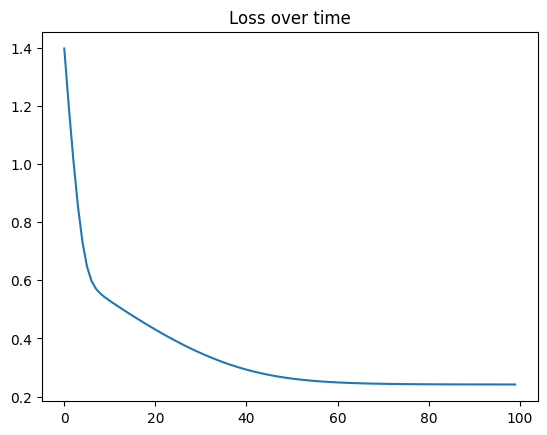

In [ ]:
w = torch.rand(2) # Our parameters
w.requires_grad = True # Explain
print(w)

optimizer = torch.optim.SGD([w], lr=0.2) # Research: What does SGD stand for?

losses = [] # Keep track of our losses (RMSE values)
ws = [] # Keep track of the values we predicted

for i in range(100):

    # Reset everything related to gradient calculations
    optimizer.zero_grad()

    # Get our outputs
    y_hat = w[0]*x + w[1]

    # Calculate our loss
    loss = rmse(y, y_hat)

    # Store the loss and a copy of the weights for later
    losses.append(loss.detach().item())
    ws.append(w.clone().detach().numpy())

    # Print out updates ever few iterations
    if (i + 1) % 20 == 0:
        print('loss at step', i, ':', loss)
        print('w at step', i, ':', w)

    # Backpropagate the loss and use it to update the parameters
    loss.backward() # This does all the gradient calculations
    optimizer.step() # The optimizer does the update.


plt.plot(losses)
plt.title('Loss over time')

Наши случайные параметры обновлялись 100 раз и сейчас близки к наилучшим:

In [ ]:
w # View the learned parameters

tensor([3.1560, 0.0374], requires_grad=True)

In [ ]:
w.grad # We can see the gradients of the loss with respect to w (now small since we're close to optimum)

tensor([-0.0064,  0.0026])

Построим график полученной линии:

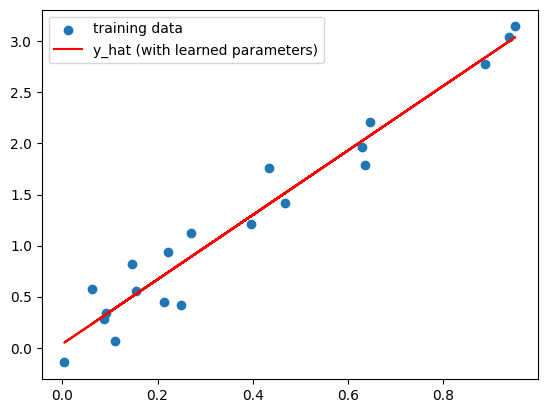

In [ ]:
plt.scatter(x, y, label='training data')
y_hat = w[0]*x + w[1]
plt.plot(x, y_hat.detach(), c='red', label='y_hat (with learned parameters)')
plt.legend();

Поскольку у нас всего два параметра, мы можем построить график, показывающий потери для каждой комбинации значений в некотором диапазоне. Мы изобразим значения параметров во время цикла оптимизации в виде точек, и вы увидите, как они медленно "движутся" к точке с меньшими потерями:

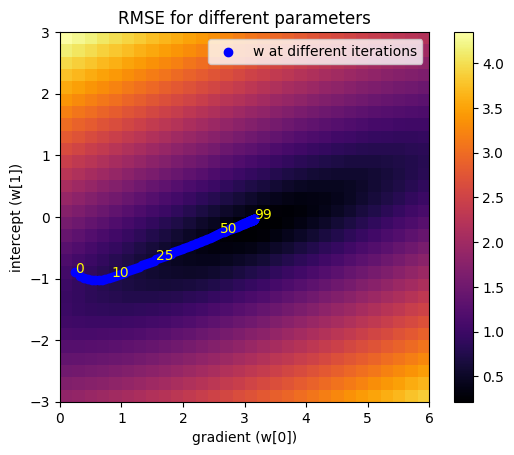

In [ ]:
w1, w2 = torch.meshgrid(torch.arange(0, 6, 0.2), torch.arange(-3, 3, 0.2), indexing='ij') # Grids with both parameters
width, height = w1.shape

# Calculating y_hat for each seat of params and then the resulting RMSEs
y_preds = x.unsqueeze(0).expand(width*height, -1) * w1.flatten().unsqueeze(0).expand(20, -1).T + w2.flatten().unsqueeze(0).expand(20, -1).T
rmses = torch.mean((y.unsqueeze(0).expand(width*height, -1)-y_preds)**2, dim=1)**0.5

# Showing the loss landscape
plt.imshow(rmses.reshape(width, height).T, cmap='inferno', extent=[0, 6, -3, 3])
plt.colorbar()
plt.title('RMSE for different parameters')
plt.xlabel('gradient (w[0])')
plt.ylabel('intercept (w[1])')

# Showing the path we took over time. We need x, -y due to the way imshow works
plt.scatter([w[0] for w in ws], [-w[1] for w in ws], c='blue', label='w at different iterations')
for i in [0, 10, 25, 50, 99]:
  plt.annotate(i, (ws[i][0], -ws[i][1]), c='yellow')
plt.legend()
plt.show()

Вместо optimizer.step() мы можем сделать `w -= w.grad * 0.2`, где 0.2 - скорость обучения, а знак минус - потому что мы хотим двигаться в направлении, уменьшающем потери (то есть в направлении, противоположном градиенту).

Попробуйте сделать это и убедитесь, что это работает. (Вам понадобится `with torch.no_grad(): w -= w.grad * 0.2`, иначе PyTorch будет жаловаться - попробуйте сначала без него, чтобы посмотреть на ошибку, с которой вы, вероятно, встретитесь еще несколько раз в жизни ;)

**Частота обучения**

![](https://i.stack.imgur.com/au77i.png)

<a name="loss"></a>
## Методы оптимизации

Градиентный спуск (или стохастический градиентный спуск (SGD), который просто работает на батчах, вместо полного набора данных) это лишь один из методов оптимизации. Существует множество более продвинутых вариантов. Если вам интересно, вот отличный обзор множества альтернатив, которые используются сегодня: https://ruder.io/optimizing-gradient-descent/.

Одна из полезных идей, которая используется в PyTorch вместе с оптимизаторами, - это регуляризация. Это большая тема, но, по сути, регуляризация направлена на сглаживание наборов параметров и упрощение моделей путем отказа от слишком экстремальных значений.

Дополнительные ресурсы: <br>
- [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0), где Анджей Карпаты обучает нейронную сеть с нуля, включая реализацию вычисления градиента и другие вещи

<a name="nn"></a>
## Простейшая нейросеть

Начнем с создания небольшой сети для решения небольшой искусственной задачи. Мы сгенерируем некоторые данные и хотим, чтобы наша сеть выучила взаимосвязь между входными (x) и выходными (y) значениями.

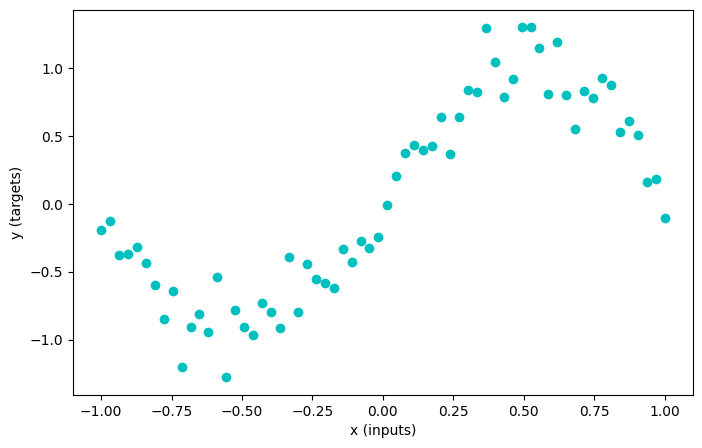

In [ ]:
n_samples = 64
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 5
targets = torch.sin(3.14 * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Вот как мы можем создать нейронную сеть с одним скрытым слоем, опираясь на удобные функции PyTorch:

In [ ]:
class WideNet(nn.Module):

    def __init__(self, n_cells=512): # Initialize our network
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, n_cells), # One input, n_cells outputs
            nn.ReLU(), # Our non-linearity - there are many on offer!
            nn.Linear(n_cells, 1), # n_cells inputs, one output
        )

    def forward(self, x):
        return self.layers(x)

Мы наследуем от класса nn.Module, что дает нам некоторые дополнительные возможности. Например, вместо прямого вызова метода forward (который передает данные через различные слои) мы можем просто вызывать свою сеть как функцию:

In [ ]:
wn = WideNet()
print('Input shape:', inputs.shape)
out = wn(inputs) # This passes our data in as the input to the forward method defined above
print('Output shape:', out.shape)
print('PyTorch sumary of wn:')
wn

Input shape: torch.Size([64, 1])
Output shape: torch.Size([64, 1])
PyTorch sumary of wn:


WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

Эта сеть включает в себя несколько слоев с обучаемыми параметрами. Мы можем получить доступ ко всем этим параметрам через `wn.parameters()` - в данном случае мы получаем четыре набора параметров - веса и смещения для каждого из двух линейных слоев. Не стесняйтесь экспериментировать с определением сети и посмотреть, как будут меняться параметры:

In [ ]:
[p.shape for p in wn.parameters()]

[torch.Size([512, 1]),
 torch.Size([512]),
 torch.Size([1, 512]),
 torch.Size([1])]

Пришло время цикла обучения - сравните его с циклом оптимизации в предыдущем уроке (спойлер: они одинаковые!). Мы оптимизируем параметры нашей нейронной сети - все веса и смещения в различных слоях.

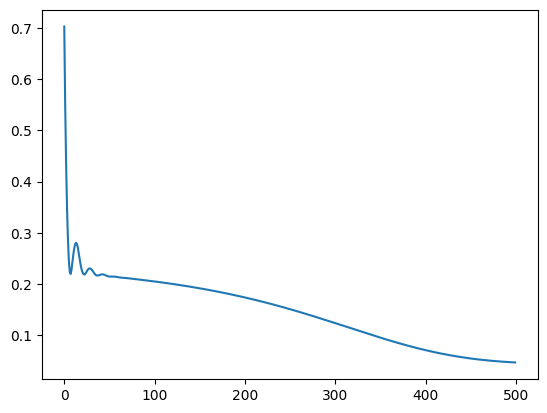

In [ ]:
# Create our network
wide_net = WideNet()

# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer
optimizer = torch.optim.Adam(wide_net.parameters(), lr=1e-3)

# The training loop
losses = []  # keeping recods of loss
for i in range(500): # 500 'epochs' of training
    optimizer.zero_grad()  # set gradients to 0
    predictions = wide_net(inputs)  # Compute model prediction (output)
    loss = loss_function(predictions, targets)  # Compute the loss
    loss.backward()  # Compute gradients (backward pass)
    optimizer.step()  # update parameters (optimizer takes a step)

    # Storing our loss for later viewing
    losses.append(loss.item())

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

Обратите внимание, что нам не нужно вручную задавать require_grad ни для одного из параметров, поскольку обучаемые параметры в каждом слое группируются автоматически с помощью `wide_net.parameters()` (посмотрите на досуге, что в нем содержится).

Посмотрим, чему модель обучилась

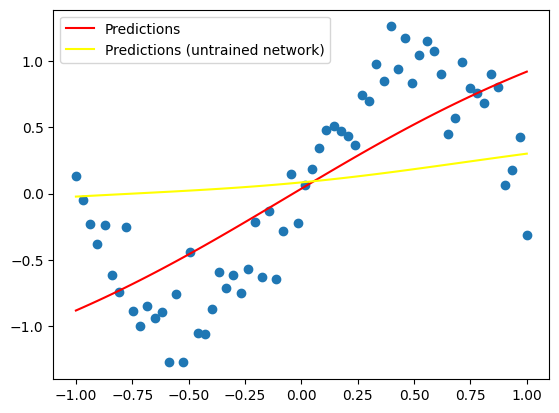

In [ ]:
plt.scatter(inputs, targets)
plt.plot(inputs, wide_net(inputs).detach(), c='red', label='Predictions')
# Create a new, untrained widenet and plot those predictions for comparison
new_wn = WideNet()
plt.plot(inputs, new_wn(inputs).detach(), c='yellow', label='Predictions (untrained network)')
plt.legend()
plt.show()

## Упражнения

* попробуйте порегулировать частоту обучения, чтобы заставить сеть расходиться или наооборот очень долго сходиться
* создайте нейросеть с двумя скрытыми слоями и обучите на той же задаче

<a name="history"></a>
## The Generative AI Timeline

© by David Foster (где-то на просторах интернета)

* 🎇 2014-2017 Эра VAE и GAN
  
  Изобретение VAE в декабре 2013 года можно считать искрой, зажегшей бумагу генеративного ИИ, за которой в 2014 году последовал первый GAN. Последующие три года были отмечены фундаментальными изменениями в архитектуре GAN-модели (DCGAN, 2015), функции потерь (Wasserstein GAN, 2017) и процессе обучения (ProGAN, 2017), а также освоением новых областей с использованием GAN, таких как перевод изображений (pix2pix, 2016 и CycleGAN, 2017) и генерация музыки (MuseGAN, 2017).

* 📝 2018-2019 Эра трансформеров

  Трансформер быстро завоевал популярность, когда был представлен GPT (трансформер, состоящий только из декодера). В последующие годы создавались все более крупные языковые модели, среди которых выделяются GPT-2 (2018, 1,5B параметров) и T5 (2019, 11B параметров).

* 🤖 2020-2022: Эра больших моделей

  В этот период произошло объединение идей из различных семейств генеративного моделирования. Например, VQ-GAN (2020) привнес дискриминатор GAN в архитектуру VQ-VAE, а Vision Transformer (2020) показал, как можно обучить трансформер работать с изображениями. В 2020 году были представлены две модели, которые заложили основу для всех будущих моделей генерации больших изображений - DDPM и DDIM. Неожиданно диффузионные модели стали конкурентами GAN по качеству генерации изображений.

  Примерно в это же время был выпущен GPT-3 (2020) - трансформер с 175B параметров. Вслед за этим был выпущен целый шквал других крупных языковых моделей, конкурирующих с GPT-3, включая Gopher (2021) и Chinchilla (2022) от DeepMind, LaMDA (2022) и PaLM (2022) от Google и OPT (2022) от Meta. Также были выпущены некоторые модели с открытым исходным кодом, такие как GPT-J (2021) и GPT-NeoX (2022) от EleutherAI и BLOOM (2022) от HuggingFace. ChatGPT (2022) - это веб-приложение и API-обертка вокруг последней версии GPT от OpenAI, позволяющая пользователям вести диалоги с ИИ.

  Тенденция развития мультимодальных моделей была заложена в DALL.E (OpenAI) - модели "текст-изображение", основанной на дискретной VAE (аналогичной VQ-VAE). За ней последовала модель DALL.E 2 (2022), в которой генеративная часть модели была обновлена и использовалась диффузионная модель.В этот период также появились модели преобразования текста в изображение от Google, такие как Imagen (2022 г., использует трансформер и диффузионную модель) и Parti (2022 г., использует трансформатор и модель ViT-VQGAN).

  Другим важным достижением стала Latent Diffusion (2021) - диффузионная модель, обучаемая в латентном пространстве автоэнкодера. На этой технологии построена модель Stable Diffusion, выпущенная компанией Stability AI. Код и весовые коэффициенты модели Stable Diffusion имеют открытый исходный код, то есть любой желающий может запустить модель на своем оборудовании.

* 🎉 2023 - Впереди зазватывающие времена...



![Generative AI Timeline by D.Foster](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/1974ad0b5a5c5998937b264c4e6b7717ed924c5e/docs/timeline.png?raw=true)